# Предобработка данных поездок и погодных условий

В этой тетрадке выполняется полный процесс подготовки данных о поездках и погоде перед дальнейшим анализом и построением моделей. Основная цель — получить **чистый, непротиворечивый и готовый к анализу набор данных**, учитывающий как характеристики поездок, так и погодные условия.

Обрабатываемые данные включают:
- Информацию о поездках: маршруты, время, стоимость, длительность и т.п.
- Погодные показатели: температура, осадки, ветер, облачность, солнечная инсоляция.

Процесс подготовки данных включает следующие ключевые этапы:

1. **Импорт библиотек и загрузка данных**
   Загрузка исходных CSV-файлов, проверка структуры данных и базовые операции по чтению.

2. **Переименование колонок**
   Приведение названий столбцов к единому формату `snake_case` для удобства дальнейшей обработки.

3. **Очистка данных о поездках**
   - Удаление дубликатов
   - Нормализация адресов и районов
   - Обработка пропусков (восстановление значений медианой по маршрутам)
   - Удаление экстремальных значений методом IQR
   - Создание новых признаков
   - Преобразование типов и категоризация признаков

4. **Очистка данных о погоде**
   - Удаление лишних столбцов и служебных строк
   - Преобразование типов данных
   - Создание признаков месяца и часа
   - Заполнение пропусков с учётом цикличности (месяц/час) и интерполяции

5. **Сохранение итоговых файлов**
   Формирование полностью очищенных датасетов, готовых к дальнейшему анализу и моделированию.

## 1. Импорт библиотек

In [1]:
import os

import pandas as pd

from utils.cleaning import (
    normalize_street, normalize_district, normalize_day_of_week,
    drop_outlers, fill_na_median_by_group, interpolate_time
)
from utils.features import get_total_price
from utils.vizualization import plot_hist_boxplot

## 2. Чтение и подготовка данных

Задаём пути к файлам, параметры чтения CSV и загружаем данные с проверкой ошибок.

In [2]:
HOME = os.getcwd().removesuffix("/notebooks")

In [3]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": f"{HOME}/data/rides.csv",
    "encoding": "utf-8",
    "parse_dates": ["Start Date", "End Date"],
}

weather_options = {
    "filepath_or_buffer": f"{HOME}/data/weather.csv",
    "encoding": "utf-8",
    "parse_dates": ["Datetime"]
}

try:
    rides_data = pd.read_csv(**rides_options)
    weather_data = pd.read_csv(**weather_options)
except pd.errors.ParserError as e:
    print(f"Error: {e}")
    rides_data = pd.read_csv(**rides_options, sep=";")
    weather_data = pd.read_csv(**weather_options, sep=";")

## 3. Переименование колонок

Приводим названия колонок к snake_case для удобства работы.

In [4]:
rides_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

weather_data.rename(lambda col: col.strip().lower().replace(" ", "_"), axis="columns", inplace=True)

## 4. Очистка данных о поездках

### 4.1. Удаление дубликатов

In [5]:
rides_data = rides_data.drop_duplicates()

rides_data.duplicated().sum()

np.int64(0)

Удаляем неявные дубликаты, повторяющиеся по id и времени старта.

### 4.2. Нормализация адресов и районов

Применяем функции из модуля `cleaning` для стандартизации названий улиц и районов.

In [6]:
rides_data["start_location"] = rides_data["start_location"].apply(normalize_street)
rides_data["end_location"] = rides_data["end_location"].apply(normalize_street)

In [7]:
rides_data["start_district"] = rides_data["start_district"].apply(normalize_district)
rides_data["end_district"] = rides_data["end_district"].apply(normalize_district)

### 4.3. Удаление пропусков
На этапе первичного анализа было выявлено, что пропусков в данных крайне мало (менее 1%). Для пропусков в колонке distance сначала применяется заполнение медианным значением для соответствующего маршрута (start_location → end_location). Это позволяет восстановить расстояние поездки на основе аналогичных маршрутов.

После заполнения оставшиеся пропуски (например, в других колонках) можно безопасно удалить, так как их доля крайне мала и это не повлияет на общую структуру данных.


In [8]:
# Заполняем пропуски в distance медианой по маршруту
rides_data = fill_na_median_by_group(rides_data, ["distance"], ["start_location", "end_location"])

# Удаляем оставшиеся строки с пропусками
rides_data.dropna(inplace=True)

# Проверка, что пропусков больше нет
rides_data.isnull().sum()

id                0
start_date        0
end_date          0
start_location    0
start_district    0
end_location      0
end_district      0
distance          0
promo             0
dtype: int64

### 4.4. Удаление экстремальных значением

Применяем метод межквартильного размаха (IQR) для очистки датасета от экстремальных значений в колонке `distance`.

In [9]:
rides_data = drop_outlers(rides_data, "distance", k=3)
rides_data = rides_data[rides_data["distance"] >= 200]

### 4.5. Создание новых признаков

Добавляем день недели и перемещаем колонку на удобную позицию.

In [10]:
rides_data["day_of_week"] = rides_data["start_date"].dt.dayofweek

col = rides_data.pop('day_of_week')
rides_data.insert(3, 'day_of_week', col)

Добавляем итоговое время поездки.

In [11]:
td = rides_data["end_date"] - rides_data["start_date"]

rides_data["duration_minutes"] = (td.dt.total_seconds() / 60).round()

Добавляем итоговую стоимость поездки.

In [12]:
rides_data["total_price"] = rides_data.apply(get_total_price, axis=1)

Добавляем признак скорости поездки (`km/ч`):

In [13]:
rides_data["speed_km_per_h"] = (rides_data["distance"] / 1000) / (rides_data["duration_minutes"] / 60)

Создаем временной признак: начало поездки, округлённое до часа (для последующего объединения с погодой)

In [14]:
rides_data['hour_timestamp'] = rides_data['start_date'].dt.floor('h')

Создаем временной признак: начало поездки, округлённое до часа (для последующего анализа корреляций)

In [15]:
rides_data['day_timestamp'] = rides_data['start_date'].dt.floor('D')

### 4.6 Оценка адекватность новых факторов

Рассмотрим распределения созданных признаков:

In [16]:
new_factors = ["duration_minutes", "total_price", "speed_km_per_h"]

In [17]:
rides_data[new_factors].describe().T

,count,mean,std,min,25%,50%,75%,max
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


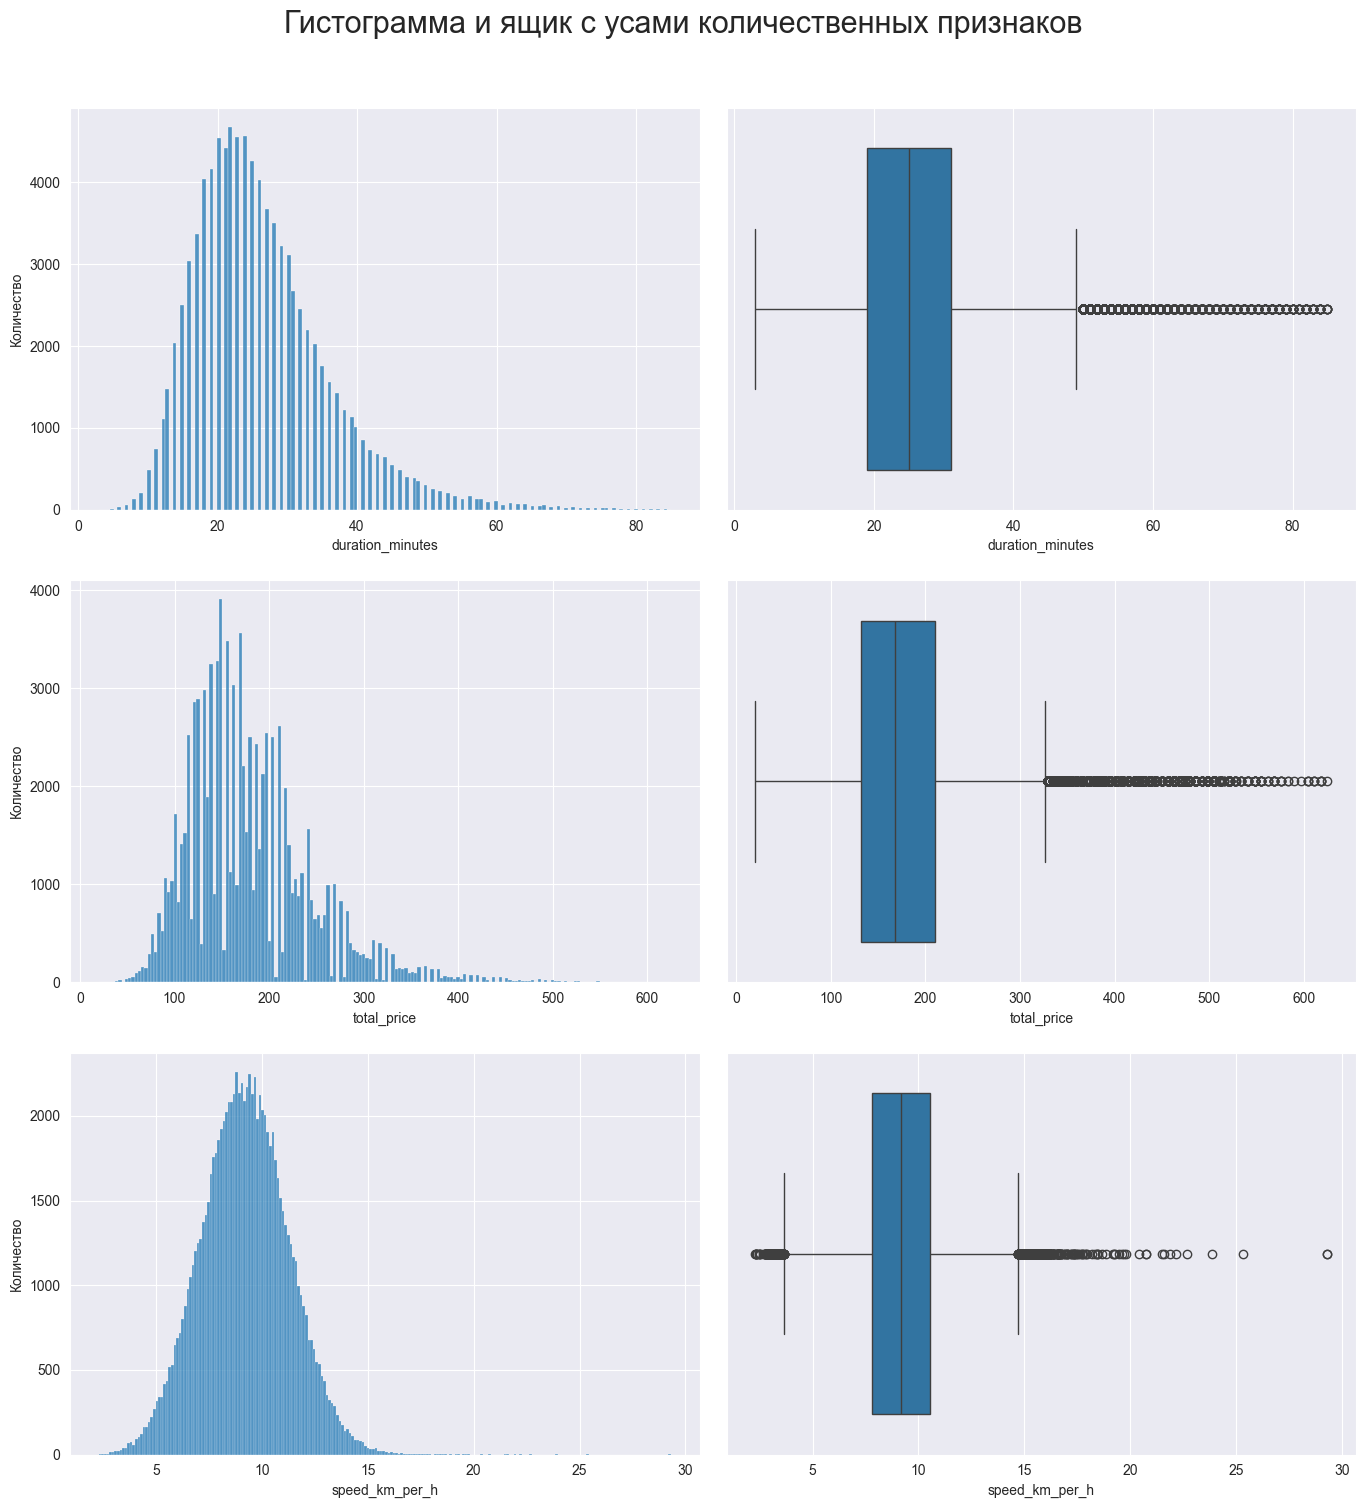

In [18]:
plot_hist_boxplot(rides_data, ["duration_minutes", "total_price", "speed_km_per_h"])

**Вывод:**

Все три признака имеют корректные диапазоны значений и реалистичные распределения. Аномалий, технических выбросов или ошибочных записей не выявлено — дополнительная очистка для данного блока не требуется.

### 4.7. Преобразование типов

Колонка `promo` содержит бинарные значения (1 — акция использована, 0 — нет).
Преобразуем её в категориальный признак и заменяем значения на "Да" / "Нет" для удобства анализа и визуализации.

In [19]:
rides_data["promo"] = rides_data["promo"].apply(lambda val: "Да" if val == 1 else "Нет")

Преобразуем числовые значения дня недели (0–6) в читаемые названия на русском языке с помощью функции normalize_day_of_week.
Колонка становится категориальной для удобства анализа и визуализации.

In [20]:
rides_data["day_of_week"] = rides_data["day_of_week"].apply(normalize_day_of_week)

Создаем признак day_of_week_type на основе нормализованного фактора day_of_week

In [21]:
rides_data["day_of_week_type"] = rides_data["day_of_week"].apply(
    lambda day: "выходной" if day in ["суббота", "воскресенье"] else "будний"
)

## 5. Очистка данных о погоде

### 5.1. Удаление ненужных столбцов

Удаляется колонка wind_gust, поскольку она дублирует информацию о порывах ветра.

In [22]:
weather_data = weather_data.drop("wind_gust", axis=1)

### 5.2. Удаление дубликатов

In [23]:
weather_data = weather_data.drop_duplicates()

weather_data.duplicated().sum()

np.int64(0)

### 5.3. Удаление первой служебной строки

Первая строка содержит единицы измерения (°C, km/h, mm и т.п.), которые не нужны для анализа, поэтому её удаляем.

In [24]:
weather_data = weather_data.iloc[1:].reset_index(drop=True)

### 5.4. Преобразование текстовых колонок в числовые

* Столбцы с типом object могут содержать текстовые значения.
* Используем pd.to_numeric(errors="coerce"), чтобы некорректные значения превратить в NaN.
* Это важно для дальнейшей интерполяции и работы с временным рядом.

In [25]:
cat_cols = weather_data.select_dtypes(include=[object]).columns
for cat in cat_cols:
    weather_data[cat] = pd.to_numeric(weather_data[cat], errors="coerce")

### 5.5. Создание новых признаков

Добавляем признак `month`.

In [26]:
weather_data["month"] = weather_data["datetime"].dt.month

col = weather_data.pop('month')
weather_data.insert(1, 'month', col)

Добавляем признак `hour`.

In [27]:
weather_data['hour'] = weather_data['datetime'].dt.hour

col = weather_data.pop('hour')
weather_data.insert(2, 'hour', col)

### 5.6. Заполнение пропусков в погодных признаках

In [28]:
# Заполняем медианой
weather_data = fill_na_median_by_group(
    weather_data, ['precipitation_total', 'temperature', 'sunshine_duration'], ['month', 'hour']
)

# Интерполируем оставшиеся признаки
weather_data = interpolate_time(
    weather_data, ['wind_speed', 'cloud_cover_total']
)

## 6. Объединяем данные о поездках с погодой по часу начала поездки

In [29]:
rides_weather_data = rides_data.merge(
    weather_data,
    left_on='hour_timestamp',
    right_on='datetime',
    how='left'
)

Проверяем, что объединение датасетов прошло корректно

In [30]:
rides_weather_data.sample(5)

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,...,day_timestamp,day_of_week_type,datetime,month,hour,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
2080,102516,2023-04-24 15:56:58,2023-04-24 16:19:29,понедельник,береговая,центральный,горького,юго-восточный,3644.5,Нет,...,2023-04-24,будний,2023-04-24 15:00:00,4,15,13.020246,0.1,15.188415,36.0,38.181816
48092,150525,2023-06-16 08:18:32,2023-06-16 08:32:39,пятница,комсомольская,заречный,трудовая,центральный,3160.0,Нет,...,2023-06-16,будний,2023-06-16 08:00:00,6,8,22.990246,0.0,2.902413,20.0,47.878788
34686,136561,2023-06-02 16:38:50,2023-06-02 16:57:57,пятница,горького,юго-восточный,красная,северо-западный,3776.0,Нет,...,2023-06-02,будний,2023-06-02 16:00:00,6,16,25.930244,0.0,15.281989,5.0,56.969700
86905,191063,2023-07-25 19:07:40,2023-07-25 19:31:52,вторник,зеленая,центральный,садовая,заречный,3039.0,Нет,...,2023-07-25,будний,2023-07-25 19:00:00,7,19,15.170245,0.6,9.339208,81.0,10.909091
58390,161287,2023-06-26 16:51:38,2023-06-26 17:11:00,понедельник,вишневая,юго-восточный,карла-маркса,ленинский,3691.0,Нет,...,2023-06-26,будний,2023-06-26 16:00:00,6,16,29.010244,0.0,15.990646,21.6,46.909092


## 7. Сохраняем очищенные файлы

In [31]:
rides_data.to_csv(f"{HOME}/data/cleaned_rides.csv", index=False)
weather_data.to_csv(f"{HOME}/data/cleaned_weather.csv", index=False)
rides_weather_data.to_csv(f"{HOME}/data/rides_weather_data.csv", index=False)